# Проверка гипотез по увеличению выручки в интернет-магазине и оценка результатов A/B теста

## Оглавление

[1  Описание проекта](#description)       
[2  Приоритезация гипотез](#hypothesis)  
- [  2.1  Вывод по разделу](#conclusion1)   

[3  Загрузка и предобработка результатов A/B-теста](#downloading)   
- [3.1  Вывод по разделу](#conclusion2)  

[4  Оценка стабильности кумулятивных метрик](#cumulative)  
- [4.1  Анализ кумулятивной выручки и кумулятивного среднего чека по группам](#revenue)   
- [4.2  Анализ кумулятивного среднего количества заказов на посетителя по группам](#visitors)   
- [4.3  Вывод по разделу](#conclusion3)  

[5  Анализ выбросов](#anomaly)   
- [5.1 Распределение заказов по пользователям](#anomaly_transaction)    
- [5.2  Распределение стоимости заказов](#anomaly_revenue)  
- [5.3  Вывод по разделу](#conclusion4)    

[6  Оценка результатов A/B-теста](#research)   
- [6.1  Cтатистическая значимость различий конверсии между группами по "сырым" данным](#conversion_dirty)   
- [6.2  Cтатистическая значимость различий в среднем чеке заказа между группами по "сырым" данным](#revenue_dirty)    
- [6.3  Очистка данных](#clean)   
- [6.4  Cтатистическая значимость различий конверсии между группами по "очищенным" данным](#conversion_clean)     
- [6.5  Cтатистическая значимость различий в среднем чеке заказа между группами по "очищенным" данным](#revenue_clean)   
- [6.6  Вывод по разделу](#conclusion5)      

[7 Результаты исследования](#result)

### Описание проекта <a id='description'></a>
Маркетинговым отделом крупного интернет-магазина подготовилен список гипотез для увеличения выручки. Используя данные интернет-магазина необходимо приоритезировать гипотезы и произвести оценку результатов A/B-тестирования различными методами.    


**Техническое задание:**    
Название теста: recomendation_block_test;    
группы: А — контрольная, B — тестовая;    
дата запуска: 2019-08-01;    
дата остановки: 2019-08-31;    
назначение теста: тестирование изменений, связанных с внедрением блоков рекомендации товаров;    
ожидаемое количество участников теста: 1000;    
ожидаемый эффект: за 31 день с начала теста пользователи покажут статистически значимое улучшение следующих метрик:    
- среднее количество заказов на посетителя,
- выручка с заказа.


**Основыне этапы исследования:**    
- Приоритезация гипотез
- Загрузка и предобработка результатов A/B-теста    
- Оценка стабильности кумулятивных метрик   
- Анализ выбросов    
- Оценка результатов A/B-теста

### Описание данных

**hypothesis.csv** содержит 9 гипотез по увеличению выручки интернет-магазина.    
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.    
Файлы с результатами A/B-теста.

**orders.csv** содержит информацию о заказах.    
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.    


**visitors.csv** содержит данные о количестве посещений.    
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Приоритезация гипотез <a id='hypothesis'></a>

In [31]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [32]:
try:
    data = pd.read_csv('/datasets/hypothesis.csv', sep=',')
except: 
    data = pd.read_csv('hypothesis.csv', sep=',')
    
pd.set_option('display.max_colwidth', None)
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Таблица содержит 9 записей с гипотезами и свойственные им параметры. Сделаем названия столбцов строчными и посчитаем приоритеты гипотез методом ICE

In [33]:
data.columns = data.columns.str.lower()
data['ice'] = ((data['impact'] * data['confidence']) / data['efforts']).round(1)
data.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


Метод ICE даёт высокий приоритет гипотезе под номером 8, предлагающей запустить акцию, дающую скидку на товар в день рождения. Также в лидеры вышли	гипотеза, предполагающая, что добавиление двух новых каналов привлечения трафика позволит привлекать на 30% больше пользователей	 и гипотеза, предлагающая добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. Посмотрим изменится ли рейтинг гипотез, если учесть параметр `reach`, для этого посчитаем приоритеты гипотнз методом RICE 

In [34]:
data['rice'] = (data['reach'] * data['impact'] * data['confidence']) / data['efforts']
data.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


При расчётах методом RICE снова в лидерах оказались две гипотезы из топа по мтоду ICE, одна из которых предполагает, что добавиление двух новых каналов привлечения трафика позволит привлекать на 30% больше пользователей, и вторая, предлагающая добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. к ним, благодаря большому значению охвата, также добавилась гипотеза о том, что добавление блоков рекомендаций товаров на сайт интернет магазина может повысить конверсию и средний чек заказа

#### Вывод <a id='conclusion1'></a>
Изменение приоритета гипотез при расчёте методами ICE и RICE связаны с тем, что фремворк RICE учитывает охват - таким образом более высокий приоритет получили гипотезы которы могут обеспечить больший овхват пользователей. Лидирующая по методу ICE гипотеза о запуске акции, дающей скидку на товар в день рождения - охватвывает небольшую долю аудитории, поэтому фреймворк RICE снизил её приоритет.    

Хотя с учётом охвата методом RICE на первом месте оказалась гипотеза, предлагающая добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок; для реализации заявленной цели по увеличению выручки больше подходит гипотеза, утверждающая, что добавление блоков рекомендаций товаров на сайт интернет магазина повысит конверсию и средний чек заказа. Эта гипотеза обладает довольно большим охватом, но окажет влияние на пользователей чуть ниже среднего по всем гипотезам, уверенность, что это изменение повлияет на пользователей именно так довольно высока. Ещё одним важным доводом в пользу проверки данной гипотезы является сравнительно невысокая стоимость её тестирования

### Загрузка и предобработка результатов A/B-теста <a id='downloading'></a>
Результаты проведенного A/B-теста описаны в файлах `orders.csv` и `visitors.csv`.    
Сначала загрузим таблицу с заказами, сразу приведя значение столбца с датой к формату `datetime`

In [35]:
try:
    orders = pd.read_csv('/datasets/orders.csv', sep=',',  parse_dates=['date'])
except: 
    orders = pd.read_csv('orders.csv', sep=',',  parse_dates=['date'])
    
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Загрузка прошла без ошибок, приведём названия столбцов к "змеиному" регистру и посмотрим информацию о выборке

In [36]:
orders = orders.rename(columns={'transactionId' : 'transaction_id', 'visitorId' : 'visitor_id'})
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


В таблице 1197 записей с заказами, типы данных в столбцах соответствуют содержащейся информации.    
Проверим наличие дубликатов в данных

In [37]:
orders.duplicated().sum()

0

Полные дубликаты отсутствуют, проверим есть ли пользователи, попавшие сразу в две группы

In [38]:
b_group = orders[orders['group'] == 'B']
a_group = orders[orders['group'] == 'A']
duplicated_users = b_group.merge(a_group, how='inner', on='visitor_id')['visitor_id'].unique()
print('Число уникальных пользователей, попавших в обе группы - ', len(duplicated_users))

Число уникальных пользователей, попавших в обе группы -  58


Обнаружено 58 пользователей, состоящих сразу в двух группах, данные о их заказах придётся удалить, чтобы они не вносили искажение в анализ результатов теста. Удалим дубликаты и посмотрим основные параметры очищенных данных

In [39]:
orders = orders[orders['visitor_id'].isin (duplicated_users) == False]

print('Всего записей - ', orders.shape[0])
print('Число уникальных пользователей - ', orders['visitor_id'].nunique())
print(f"Количество заказов группы A - {len(orders.loc[orders['group'] == 'A'])}")
print(f"Количество заказов группы B - {len(orders.loc[orders['group'] == 'B'])}")
print(f"Уникальных пользователей группы А - {orders.loc[orders['group'] == 'A']['visitor_id'].nunique()}")
print(f"Уникальных пользователей группы B - {orders.loc[orders['group'] == 'B']['visitor_id'].nunique()}")

diference = 1- (orders.loc[orders['group'] == 'A']['visitor_id'].nunique() / 
    orders.loc[orders['group'] == 'B']['visitor_id'].nunique())
print(f'Различие групп по размеру - {diference:.1%}')

print('Дата начала теста - ', min(orders['date'].dt.date))
print('Дата окончания теста - ', max(orders['date'].dt.date))

Всего записей -  1016
Число уникальных пользователей -  973
Количество заказов группы A - 468
Количество заказов группы B - 548
Уникальных пользователей группы А - 445
Уникальных пользователей группы B - 528
Различие групп по размеру - 15.7%
Дата начала теста -  2019-08-01
Дата окончания теста -  2019-08-31


Итоговая таблица с заказами содержит 1016 записей, что является достаточной выборкой для оценки результатов A/B-теста. Тест длился 31 день, в нём приняли участие 973 пользователя. Стоит обратить внимание на то, что тест проходил в августе, когда в разгаре сезон отпусков и это могло повлиять на поведение пользователей.         
Далее приступим к загрузке данных о посещениях платформы

In [40]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',', parse_dates=['date'])
except: 
    visitors = pd.read_csv('visitors.csv', sep=',', parse_dates=['date'])
    
visitors.sort_values(by='date').head()

,date,group,visitors
0,2019-08-01,A,719
31,2019-08-01,B,713
1,2019-08-02,A,619
32,2019-08-02,B,581
2,2019-08-03,A,507


Загрузка прошла без ошибок, посмотрим информацию о полученных данных

In [41]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


В данных 62 записи, тест длился 31 день. Типы данных соответствуют содержащейся в столбцах информации. Проверим наличие дубликатов

In [42]:
visitors.duplicated().sum()

0

Дубликаты отсутствуют

#### Вывод <a id='conclusion2'></a>    
Загрузка данных прошла без ошибок. Столбцы с информацией о дате заказа приведены к формату `datetime`. После очистки данных от дубликатов в таблице с заказами осталось 1016 записей о заказах 973 уникальных пользователей, что является достаточной выборкой для оценки результатов A/B-теста. Таблица с данными о посещениях содержит информацию о количестве посещений платформы в течение 31 дня. Типы данных в таблицах соответствуют содержащейся в столбцах информации, дубликаты отсутствуют. Данные готовы для дальнейшего анализа.    
Стоит обратить внимание, что тест проходил в августе, когда в разгаре сезон отпусков, в связи с чем, не лишним будет дополнительно проанализировать, мог ли этот фактор оказать влияние на поведение пользователей.

### Оценка стабильности кумулятивных метрик <a id='cumulative'></a>

Чтобы исключить проблему подсматривания, проанализируем графики накапливаемых данных. По центральной предельной теореме значение кумулятивных метрик часто сходится и устанавливается около некоторого среднего, исходя из этого, по графику кумулятивных метрик сможем определить, стоит останавливать тест или нет

Для создания графиков подготовим кумулятивные данные по заказам и посещениям.    
Начнём с расчёта кумулятивных данных по посещениям

In [43]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_a']

visitors_a_cum = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_a': 'sum'}), axis=1)
visitors_a_cum.columns = ['date', 'visitors_cumulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_b']

visitors_b_cum = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_b': 'sum'}), axis=1)
visitors_b_cum.columns = ['date', 'visitors_cumulative_b']

visitors_data = (
    visitors_a_daily.merge(
        visitors_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(visitors_a_cum, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cum, left_on='date', right_on='date', how='left')
)

visitors_data.head()

,date,visitors_a,visitors_b,visitors_cumulative_a,visitors_cumulative_b
0,2019-08-01,719,713,719,713
1,2019-08-02,619,581,1338,1294
2,2019-08-03,507,509,1845,1803
3,2019-08-04,717,770,2562,2573
4,2019-08-05,756,707,3318,3280


Кумулятивные данные по посещениям выглядят правдоподобно, теперь посчитаем кумулятивные данные по заказам и объединим таблицы

In [44]:
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_a', 'revenue_a']

orders_a_cum = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_a': 'sum', 'revenue_a': 'sum'}
    ),
    axis=1
).sort_values(by=['date'])
orders_a_cum.columns = [
    'date',
    'orders_cumulative_a',
    'revenue_cumulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_b', 'revenue_b']

orders_b_cum = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_b': 'sum', 'revenue_b': 'sum'}
    ),
    axis=1
).sort_values(by=['date'])
orders_b_cum.columns = [
    'date',
    'orders_cumulative_b',
    'revenue_cumulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cum, left_on='date', right_on='date', how='left')
    .merge(orders_b_cum, left_on='date', right_on='date', how='left')
    .merge(visitors_data, left_on='date', right_on='date', how='left')
)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   31 non-null     datetime64[ns]
 1   orders_a               31 non-null     int64         
 2   revenue_a              31 non-null     int64         
 3   orders_b               31 non-null     int64         
 4   revenue_b              31 non-null     int64         
 5   orders_cumulative_a    31 non-null     int64         
 6   revenue_cumulative_a   31 non-null     int64         
 7   orders_cumulative_b    31 non-null     int64         
 8   revenue_cumulative_b   31 non-null     int64         
 9   visitors_a             31 non-null     int64         
 10  visitors_b             31 non-null     int64         
 11  visitors_cumulative_a  31 non-null     int64         
 12  visitors_cumulative_b  31 non-null     int64         
dtypes: date

,date,orders_a,revenue_a,orders_b,revenue_b,orders_cumulative_a,revenue_cumulative_a,orders_cumulative_b,revenue_cumulative_b,visitors_a,visitors_b,visitors_cumulative_a,visitors_cumulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Данные объединены без потерь и пропусков. В итоговой таблице 31 запись с раделёнными по группам ежедневной посещаемостью и выручкой, а также эти параметры, рассчитанные с накоплением

#### Анализ кумулятивной выручки и кумулятивного среднего чека по группам <a id='revenue'><a>
Построим график кумулятивной выручки по группам.

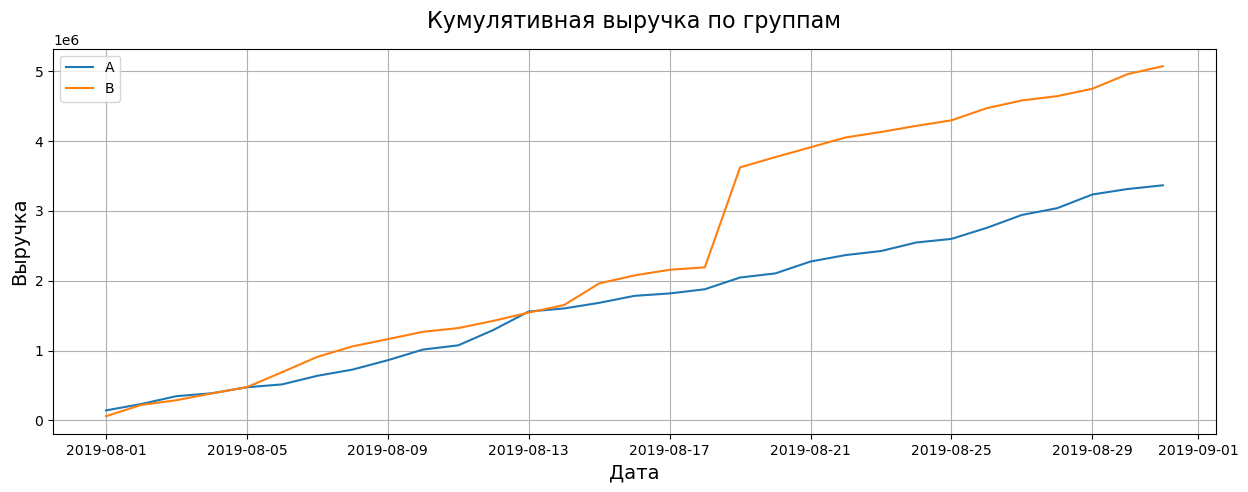

In [45]:
plt.figure(figsize=(15,5))
# Строим график выручки группы А
plt.plot(data['date'], data['revenue_cumulative_a'], label='A')
# Строим график выручки группы B
plt.plot(data['date'], data['revenue_cumulative_b'], label='B')

plt.title('Кумулятивная выручка по группам', loc ='center', pad = 15, fontsize=16, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Дата', fontsize=14, color='black')
plt.ylabel('Выручка', fontsize=14, color='black')
plt.xticks(rotation=0, ha='center')
plt.grid()
plt.legend() 
plt.show()  

Выручка почти равномерно увеличивается в течение всего теста, однако график выручки группы "B" резко растёт 19 августа 2019, это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы проанализируем в ходе дальнейшего исследования

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:


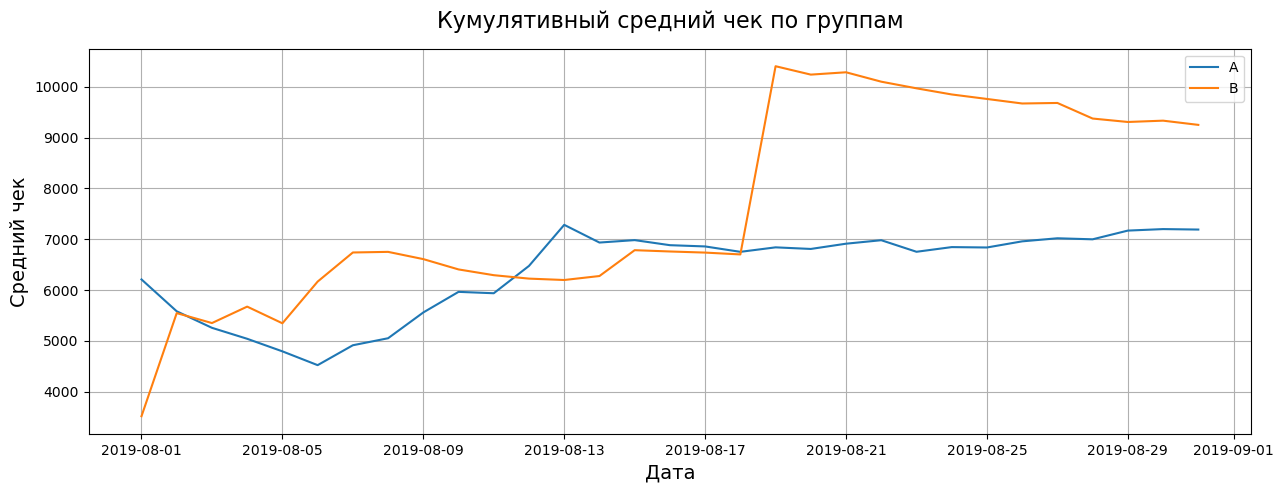

In [46]:
plt.figure(figsize=(15,5))
# Строим график выручки группы А
plt.plot(data['date'], (data['revenue_cumulative_a'] / data['orders_cumulative_a']), label='A')
# Строим график выручки группы B
plt.plot(data['date'], (data['revenue_cumulative_b'] / data['orders_cumulative_b']), label='B')

plt.title('Кумулятивный средний чек по группам', loc ='center', pad = 15, fontsize=16, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Дата', fontsize=14, color='black')
plt.ylabel('Средний чек', fontsize=14, color='black')
plt.xticks(rotation=0, ha='center')
plt.grid()
plt.legend() 
plt.show()  

Средний чек тоже становится равномерным ближе к концу теста. Возможно, в группу "B" 19 августа попали крупные заказы (резкий всплеск на графике), тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне

Чтобы подтвердить влияние выбросов на кумулятивный средний чек и выручку, построим график относительного изменения кумулятивного среднего чека группы B к группе A

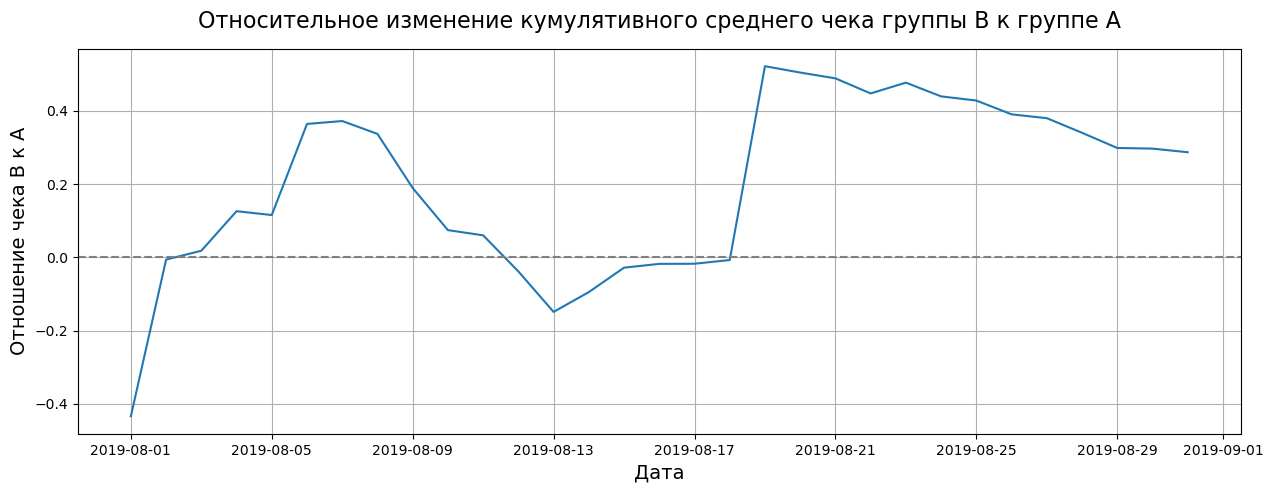

In [47]:
plt.figure(figsize=(15,5))
# cтроим отношение средних чеков
plt.plot(data['date'], (data['revenue_cumulative_b'] / data['orders_cumulative_b']) 
         / (data['revenue_cumulative_a'] / data['orders_cumulative_a'])-1)
# добавляем ось X
plt.axhline(y=0, color='grey', linestyle='--') 

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', loc ='center', pad = 15, fontsize=16, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Дата', fontsize=14, color='black')
plt.ylabel('Отношение чека B к A', fontsize=14, color='black')
plt.xticks(rotation=0, ha='center')
plt.grid()
plt.show()  

В нескольких точках график различия между сегментами резко «скачет», что свидетельствует о влиянии крупных заказов и выбросов, которые нам предстоит найти при дальнейшем исследовании

#### Анализ кумулятивного среднего количества заказов на посетителя по группам <a id='visitors'></a>

На следующем этапе изучим изменение кумулятивного среднего количества заказов на посетителя по группам

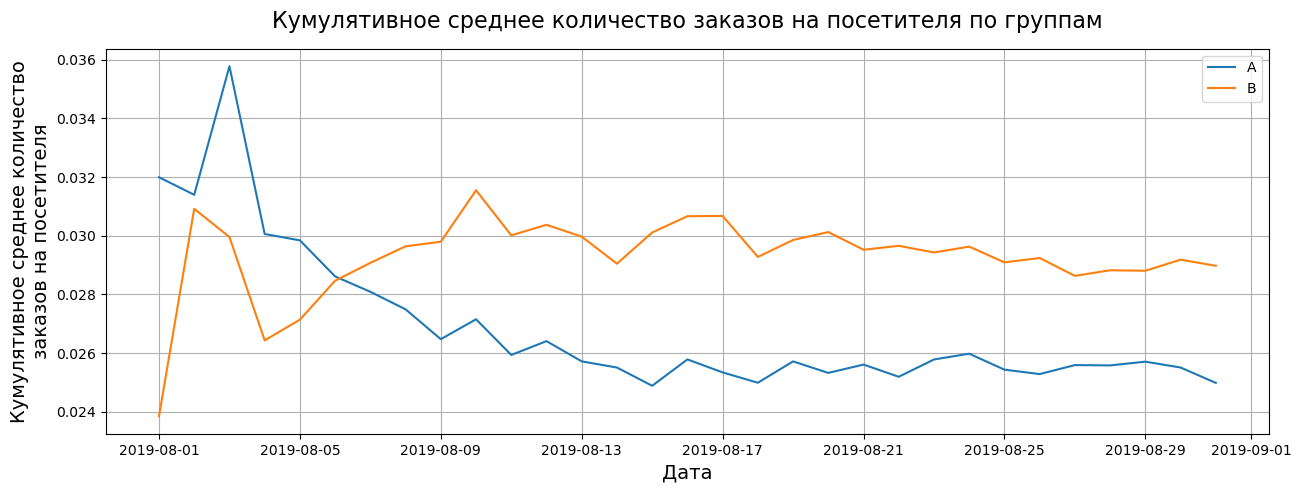

In [48]:
plt.figure(figsize=(15,5))
plt.plot(data['date'], (data['orders_cumulative_a'] / data['visitors_cumulative_a']), label='A')
plt.plot(data['date'], (data['orders_cumulative_b'] / data['visitors_cumulative_b']), label='B')

plt.title('Кумулятивное среднее количество заказов на посетителя по группам', loc ='center', pad = 15, fontsize=16, \
             color='black', backgroundcolor='white', fontstyle='normal', wrap=True)
plt.xlabel('Дата', fontsize=14, color='black')
plt.ylabel('Кумулятивное среднее количество\nзаказов на посетителя', fontsize=14, color='black')
plt.xticks(rotation=0, ha='center')
plt.grid()
plt.legend() 
plt.show()  

В начале теста, как и предполагалось, данные показывают сильные колебания значений, но затем конверсия группы "B" выросла и стабилизировалась, а конверсия группы "A", наоборот, просела и также зафиксировалась

Чтобы нагляднее увидеть разницу между группами, построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

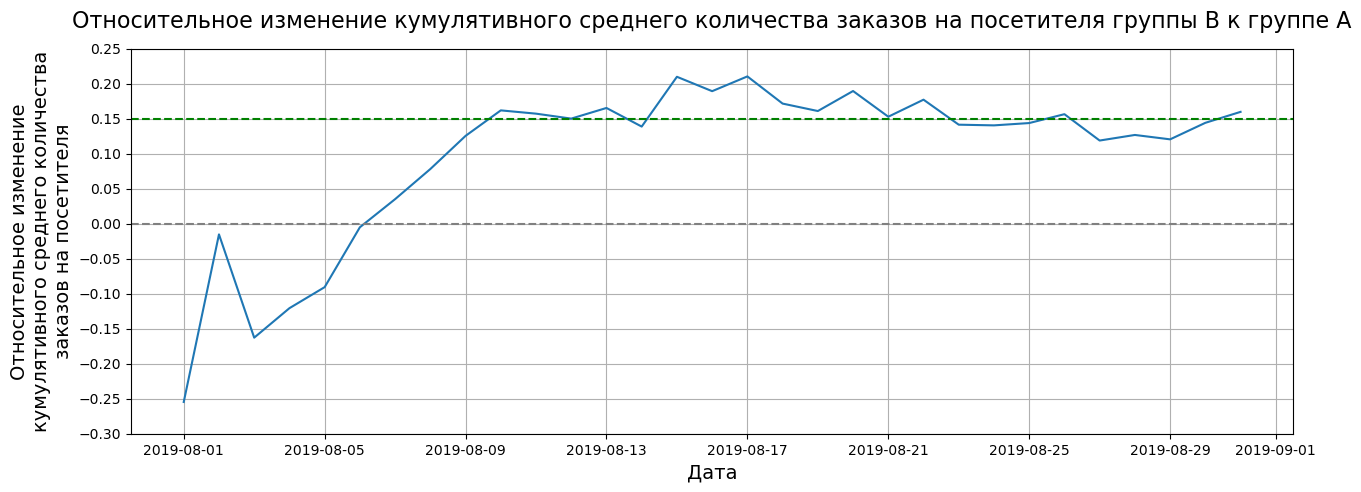

In [49]:
plt.figure(figsize=(15,5))
plt.plot(data['date'], (data['orders_cumulative_b'] / data['visitors_cumulative_b'])
         /(data['orders_cumulative_a'] / data['visitors_cumulative_a'])-1)
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=0.15, color='green', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A', 
          loc ='center', pad = 15, fontsize=16, color='black', backgroundcolor='white', fontstyle='normal', wrap=True)
plt.xlabel('Дата', fontsize=14, color='black')
plt.ylabel('Относительное изменение\nкумулятивного среднего количества\nзаказов на посетителя', fontsize=14, color='black')
plt.xticks(rotation=0, ha='center')
plt.yticks(np.arange(-0.3, 0.3, 0.05))
plt.grid()
plt.show()  

В ходе теста группа "B" показывала рост конверсии, которая в итоге стабилизировалась около значения примерно 15% относительно группы А

#### Вывод <a id='conclusion3'></a>    

Для оценки стабильности кумулятивных метрик свели данные в таблицу, содержащую 31 запись с раделёнными по группам ежедневной посещаемостью и выручкой, а также эти параметры, рассчитанные с накоплением. Объединение данных прошло без потерь и пропусков.   

Анализ выручки:    

График кумулятивной выручки по группам показал, что выручка почти равномерно увеличивалась в течение всего теста, однако график выручки группы "B" резко растёт 19 августа 2019, это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. График среднего чека по группам тоже становится равномерным ближе к концу теста, но и он показывает всплеск значений в группе "B" 19 августа, если это является следствием попадания в неё крупных заказов, тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. Для подтверждения влияния выбросов на кумулятивный средний чек и выручку, построили график относительного изменения кумулятивного среднего чека группы B к группе A, который показал резкие скачки в нескольких точках, что свидетельствует о влиянии крупных заказов и выбросов, которые нам предстоит найти при дальнейшем исследовании.

Анализ конверсии:    

Анализ кумулятивного среднего количества заказов на посетителя по группам показал что в начале теста прослеживались сильные колебания значений, но затем конверсия группы "B" выросла и стабилизировалась, а конверсия группы "A", наоборот, просела и также зафиксировалась.
График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A подтвердил, что в ходе теста группа "B" показывала рост конверсии, которая в итоге стабилизировалась около значения примерно 15% относительно группы А

Как и предполагает центральная предельная теорема, значения кумулятивных метрик установились около некоторого среднего. Исходя из этого, можем определить, что проблема подсматривания исключена и тест можно остановить, но графики показали и возможность наличия выбросов, которые предстоит обнаружить и исключить их влияние на окончательный результат

### Анализ выбросов <a id='anomaly'></a>
На данном этапе проанализируем аномалии, возможно, они изменят картину

#### Распределение заказов по пользователям <a id='anomaly_transaction'></a>

Сначала рассмотрим как распределяется количество заказов по пользователям, для этого построим построим точечный график

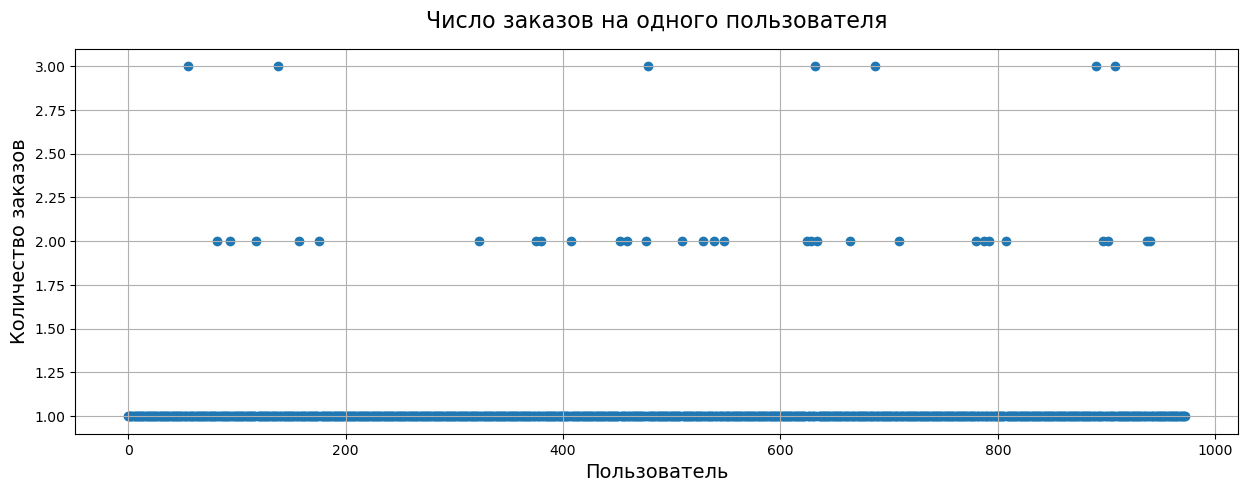

In [50]:
plt.figure(figsize=(15,5))
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'}))

orders_by_users.columns = ['user_id', 'orders']
x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders']) 


plt.title('Число заказов на одного пользователя', loc ='center', pad = 15, fontsize=16, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Пользователь', fontsize=14, color='black')
plt.ylabel('Количество заказов', fontsize=14, color='black')
plt.xticks(rotation=0, ha='center')
plt.grid()
plt.show()  

Большинство покупателей заказывали только один раз, однако прослеживаются пользователи с 2-3 заказами, чтобы определить, считать их аномалиями или нет, посчитаем выборочные перцентили количества заказов на одного пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [51]:
anomaly_orders = np.percentile(orders_by_users['orders'], [95, 99])
print(f'99% пользователей делают не более {int(anomaly_orders[1])} заказов, '
      f'95% пользователей делают не более {int(anomaly_orders[0])} заказа')

99% пользователей делают не более 2 заказов, 95% пользователей делают не более 1 заказа


Только 1% пользователей оформили больше чем 2 заказа. И 5% пользователей заказывали более одного раза.
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней

#### Распределение стоимости заказов <a id='anomaly_revenue'></a>

На следующем этапе посмотрим как распределяются значения стоимостей заказов

count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
25%      1.190000e+03
50%      2.955000e+03
75%      8.134250e+03
max      1.294500e+06
Name: revenue, dtype: float64

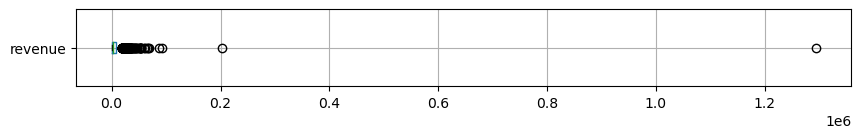

In [52]:
display(orders['revenue'].describe())
orders.boxplot(column='revenue', vert=False, figsize=(10, 1));

В данных присутствуют одиночные выбросы, а большинство значений не превышают порог в 100000. Уберем явные выбросы и посмотрим подробнее как распределяются значения на точечном графике

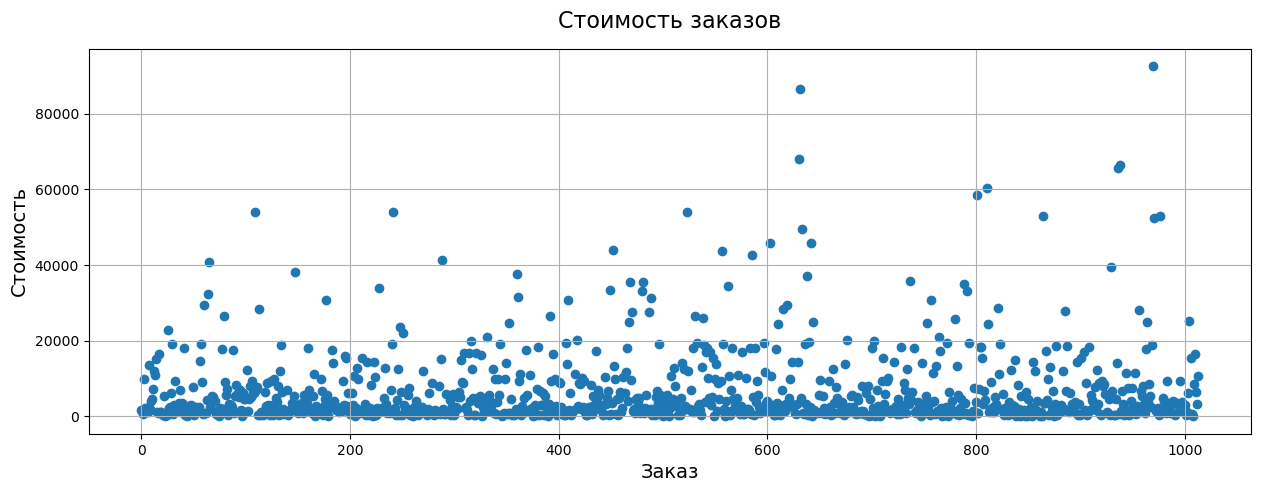

In [53]:
plt.figure(figsize=(15,5))
good_orders = orders.query('revenue <= 100000')
x_values = pd.Series(range(0,len(good_orders['revenue'])))
plt.scatter(x_values, good_orders['revenue'])

plt.title('Стоимость заказов', loc ='center', pad = 15, fontsize=16, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Заказ', fontsize=14, color='black')
plt.ylabel('Стоимость', fontsize=14, color='black')
plt.xticks(rotation=0, ha='center')
plt.grid()
plt.show()  

График показывает, что стоимости большей части заказов редко превышают 20000.    
Определим точную границу, по которой можно отсеять аномальные значения

In [54]:
anomaly_revenue = np.percentile(good_orders['revenue'], [95, 99])
print(f'99% пользователей делают заказ на сумму менее {int(anomaly_revenue[1])}, '
      f'95% пользователей делают заказ на сумму менее {int(anomaly_revenue[0])}')

99% пользователей делают заказ на сумму менее 52900, 95% пользователей делают заказ на сумму менее 26550


Не более 5% заказов дороже 26550 и не более 1% дороже 52900. Примем за верхнюю границу стоимости заказа значение 30000, остальные будем считать аномальными

#### Вывод <a id='conclusion4'></a>     

Для поисков выбросов в количестве заказов по пользователям, построили точечный график, который показал, что большинство покупателей делали заказ только один раз, однако прослеживаются пользователи с 2-3 заказами. Чтобы определить, считать их аномалиями или нет, посчитали 95-й и 99-й перцентили количества заказов на пользователя и установили, что только 1% пользователей оформили больше чем 2 заказа и 5% пользователей заказывали более одного раза. За верхнюю границу чистых данных, по которой будем отсеивать аномальные значения, выбрали 2 заказа на одного пользователя.

При поиске выбросов в распределении стоимости заказов график boxplot показал наличие в данных одиночных выбросов, после устранения которых на точечном графике увидели, что стоимости основной массы заказов редко превышают 20000. Для определения точной границы, по которой можно отсеять аномальные значения посчитали 95-й и 99-й перцентили распределения стоимости заказов и установили, что не более 5% заказов дороже 26550 и не более 1% дороже 52900. За верхнюю границу стоимости заказа приняли значение 30000, остальные будем считать аномальными

### Оценка результатов A/B-теста <a id='research'></a>

После визуальных оценок результатов теста посчитаем статистическую значимость различий среднем числе заказов на пользователя и среднем чеке между группами по критерию Манна-Уитни

#### Cтатистическая значимость различий конверсии между группами по "сырым" данным <a id='conversion_dirty'></a>

Начнём с рассчета статистической значимости различий конверсии между группами по сырым данным.    

Сформулируем гипотезы:    
Нулевая гипотеза (H0): различий в среднем количестве заказов между группами нет.    
Альтернативная гипотеза (H1): различия в конверсии между группами есть.    
Уровень статистической значимости зададим в 5%

In [55]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Прирост конверсии группы В к конверсии группы А:', '{0:.2%}'.format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.011
Прирост конверсии группы В к конверсии группы А: 15.98%


Полученное значение P-value 0.011 меньше уровня статистической значимости 0.05, поэтому нулевую гипотезу отвергаем, различия в конверсии между группами прослеживаются, в пользу этого говорит и относительный прирост конверсии группы В к конверсии группы А, равный 15.98%.


#### Cтатистическая значимость различий в среднем чеке заказа между группами по "сырым" данным <a id='revenue_dirty'></a>

Далее рассчитаем статистическую значимость различия средних чеков между группами по сырым данным.    

Сформулируем гипотезы:        
Нулевая гипотеза (H0) - Различий в среднем чеке между группами нет    
Альтернативная гипотеза (H1) - Есть различия в среднем чеке между группами    
Уровень статистической значимости зададим в 5%    

Для расчёта статистической значимости различий в среднем чеке, передадим критерию `mannwhitneyu()` данные о выручке с заказов

In [56]:
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                      orders[orders['group']=='B']['revenue'])[1]))
print('Относительная разница среднего чека между сегментами:', 
      '{0:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.829
Относительная разница среднего чека между сегментами: 28.66%


Полученное значение P-value 0.829 превышает уровень статистической значимости 0.05, это подтверждает нулевую гипотезу об отсутствии различий в среднем чеке между группами, однако расчётная разница в среднем чеке между группами составляет 28.66%, что может быть следствием влияния аномальных значений, чтобы проверить это, очистим данные от выбросов

#### Очистка данных <a id='clean'></a>

Рассчитанные ранее 95-й и 99-й перцентили средних чеков равны 26550 и 52900. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 30000 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — `many_orders_users` и пользователей, совершивших заказы дороже 30000 — `expensive_orders_users`. Объединим их в таблице `abnormal_users`

Узнаем, сколько всего аномальных пользователей атрибутом shape

In [57]:
many_orders_users = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['user_id'],
    ],
    axis=0,
)
expensive_orders_users = orders[orders['revenue'] > 30000]['visitor_id']
abnormal_users = (
    pd.concat([many_orders_users, expensive_orders_users], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Количество аномальных пользователей -', abnormal_users.shape[0]) 

Количество аномальных пользователей - 49


Обнаружено 49 аномальных пользователей. Чтобы узнать, как их действия повлияли на результаты теста, сначала подготовим очищенные выборки количества заказов по пользователям по группам теста

In [58]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 


#### Cтатистическая значимость различий конверсии между группами по "очищенным" данным <a id='conversion_clean'></a>

Для расчёта статистической значимости различий в среднем количестве заказов между группами теста, применим статистический критерий Манна-Уитни к полученным очищенным выборкам.    

Сформулируем гипотезы:    
Нулевая гипотеза (H0): различий в среднем количестве заказов между группами нет.    
Альтернативная гипотеза (H1): различия в конверсии между группами есть.    
Уровень статистической значимости зададим в 5%

In [59]:
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Прирост конверсии группы В к конверсии группы А:', 
      '{0:.2%}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

P-value: 0.010
Прирост конверсии группы В к конверсии группы А: 18.73%


Результаты по среднему количеству заказов практически не изменились, полученное значение P-value 0.01 меньше уровня статистической значимости 0.05, поэтому нулевую гипотезу отвергаем, различия в конверсии между группами прослеживаются, этого подтверждает и относительный прирост конверсии группы В к конверсии группы А, равный 18.73%, который при очистке данных увеличился почти на 3 процентных пункта

#### Cтатистическая значимость различий в среднем чеке заказа между группами по "очищенным" данным <a id='revenue_clean'></a>

Далее рассчитаем статистическую значимость различия средних чеков между группами по "очищенным" данным.    

Сформулируем гипотезы:    
Нулевая гипотеза (H0) - Различий в среднем чеке между группами нет    
Альтернативная гипотеза (H1) - Есть различия в среднем чеке между группами    
Уровень статистической значимости зададим в 5%    

Для расчёта статистической значимости различий в среднем чеке, передадим критерию mannwhitneyu() очищенные данные о выручке с заказов

In [60]:
print('P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            True, # четвёртый параметр 
            'two-sided' # двухсторонний тест по умолчанию
        )[1]
    )
)

print('Относительная разница среднего чека между сегментами:',
    "{0:.2%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.741
Относительная разница среднего чека между сегментами: -2.66%


Полученное по очищенным от выбросов данным значение P-value 0.741 превышает уровень статистической значимости 0.05, это вновь подтверждает нулевую гипотезу об отсутствии различий в среднем чеке между группами, также в пользу нулевой гипотезы говорит и полученная из чистых данных незначительная расчётная разница в среднем чеке между группами, составляющая 2.66%.

#### Вывод <a id='conclusion5'></a>

Для оценки результатов A/B-теста посчитали статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по критерию Манна-Уитни по "сырым" и "очищенным" данным. При очистке данных приняли за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 30000 рублей. Так мы убрали 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Всего было обнаружено 49 аномальных пользователей.

Для конверсии были выдвинуты гипотезы:    
Нулевая гипотеза (H0) - различий в среднем количестве заказов между группами нет.    
Альтернативная гипотеза (H1): различия в конверсии между группами есть.    
Уровень статистической значимости задали в 5%

Вычислив статистическую значимости различий конверсии между группами по сырым данным получили значение P-value 0.011, что меньше уровня статистической значимости 0.05, поэтому нулевую гипотезу отвергли, различия в конверсии между группами прослеживаются, в пользу этого говорил и относительный прирост конверсии группы В к конверсии группы А, равный 15.98%.
Результаты по среднему количеству заказов для очищенных данных практически не изменились, полученное значение P-value 0.01 меньше уровня статистической значимости 0.05, поэтому нулевую гипотезу вновь отвергли, различия в конверсии между группами присутствуют, этого подтверждает и относительный прирост конверсии группы В к конверсии группы А, равный 18.73%, который после очистки данных увеличился почти на 3 процентных пункта.

Для расчет статистической значимости различия средних чеков между группами были сформирмулированы гипотезы:    
Нулевая гипотеза (H0) - Различий в среднем чеке между группами нет.    
Альтернативная гипотеза (H1) - Есть различия в среднем чеке между группами.    
Уровень статистической значимости задали в 5%    

Для сырых данных полученное значение P-value 0.829 превысило уровень статистической значимости 0.05, что подтвердило нулевую гипотезу об отсутствии различий в среднем чеке между группами, однако расчётная разница в среднем чеке между группами составила 28.66%, что явилось следствием влияния аномальных значений, после устранения которых, полученное по очищенным от выбросов данным значение P-value составило 0.741, вновь превысив уровень статистической значимости 0.05 и подтвердив нулевую гипотезу об отсутствии различий в среднем чеке между группами, но на этот раз, в пользу нулевой гипотезы говорила и полученная из чистых данных незначительная расчётная разница в среднем чеке между группами, составляющая 2.66%.

### Результаты исследования    <a id='result'></a>    

Для увеличения выручки крупного интернет-магазина из подготовиленого списка гипотез методом RICE была выбрана гипотеза под номером 2, утверждающая, что добавление блоков рекомендаций товаров на сайт интернет магазина повысит конверсию и средний чек заказа. Заявленные в гипотезе рост конверсии и среднего чека должны решить поставленную задачу увеличения выручки, эта гипотеза обладает довольно большим охватом, но оказывает влияние на пользователей чуть ниже среднего по всем гипотезам, уверенность, что это изменение повлияет на пользователей именно так довольно высока. Ещё одним важным доводом в пользу проверки данной гипотезы является сравнительно невысокая стоимость её тестирования.

Загрузка результатов A/B-теста прошла без ошибок. Столбцы с информацией о дате заказа приведены к формату datetime. После очистки данных от дубликатов в таблице с заказами осталось 1016 записей о заказах 973 уникальных пользователей, что является достаточной выборкой для оценки результатов A/B-теста. Таблица с данными о посещениях содержит информацию о количестве посещений платформы в течение 31 дня. Типы данных в таблицах соответствуют содержащейся в столбцах информации, дубликаты отсутствуют. Данные подготовлены для дальнейшего анализа.

Для оценки стабильности кумулятивных метрик свели данные в таблицу, содержащую 31 запись с раделёнными по группам ежедневной посещаемостью и выручкой, а также эти параметры, рассчитанные с накоплением. Объединение данных прошло без потерь и пропусков.

Анализ выручки:

График кумулятивной выручки по группам показал, что выручка почти равномерно увеличивалась в течение всего теста, однако график выручки группы "B" резко растёт 19 августа 2019, это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. График среднего чека по группам тоже становится равномерным ближе к концу теста, но и он показывает всплеск значений в группе "B" 19 августа, если это является следствием попадания в неё крупных заказов, тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. Для подтверждения влияния выбросов на кумулятивный средний чек и выручку, построили график относительного изменения кумулятивного среднего чека группы B к группе A, который показал резкие скачки в нескольких точках, что свидетельствует о влиянии крупных заказов и выбросов, которые нам предстоит найти при дальнейшем исследовании.

Анализ конверсии:

Анализ кумулятивного среднего количества заказов на посетителя по группам показал что в начале теста прослеживались сильные колебания значений, но затем конверсия группы "B" выросла и стабилизировалась, а конверсия группы "A", наоборот, просела и также зафиксировалась. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A подтвердил, что в ходе теста группа "B" показывала рост конверсии, которая в итоге стабилизировалась около значения примерно 15% относительно группы А

Как и предполагает центральная предельная теорема, значения кумулятивных метрик установились около некоторого среднего. Исходя из этого, можем определить, что проблема подсматривания исключена и тест можно остановить, но графики показали и возможность наличия выбросов, которые в ходе дальнейшего исследования были обнаружены и устранены.

Для поисков выбросов в количестве заказов по пользователям, построили точечный график, который показал, что большинство покупателей делали заказ только один раз, однако прослеживаются пользователи с 2-3 заказами. Чтобы определить, считать их аномалиями или нет, посчитали 95-й и 99-й перцентили количества заказов на пользователя и установили, что только 1% пользователей оформили больше чем 2 заказа и 5% пользователей заказывали более одного раза. За верхнюю границу чистых данных, по которой будем отсеивать аномальные значения, выбрали 2 заказа на одного пользователя.

При поиске выбросов в распределении стоимости заказов график boxplot показал наличие в данных одиночных выбросов, после устранения которых на точечном графике увидели, что стоимости основной массы заказов редко превышают 20000. Для определения точной границы, по которой можно отсеять аномальные значения посчитали 95-й и 99-й перцентили распределения стоимости заказов и установили, что не более 5% заказов дороже 26550 и не более 1% дороже 52900. За верхнюю границу стоимости заказа приняли значение 30000, остальные стали считать аномальными

Для оценки результатов A/B-теста посчитали статистическую значимость различий среднем числе заказов на пользователя и среднем чеке между группами по критерию Манна-Уитни по "сырым" и "очищенным" данным. При очистке данных приняли за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 30000 рублей. Так мы убрали 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Всего было обнаружено 49 аномальных пользователей.

Для конверсии были выдвинуты гипотезы:
Нулевая гипотеза (H0) - различий в среднем количестве заказов между группами нет.
Альтернативная гипотеза (H1): различия в конверсии между группами есть.
Уровень статистической значимости задали в 5%

Вычислив статистическую значимости различий конверсии между группами по сырым данным получили значение P-value 0.011, что меньше уровня статистической значимости 0.05, поэтому нулевую гипотезу отвергли, различия в конверсии между группами прослеживались, в пользу этого говорил и относительный прирост конверсии группы В к конверсии группы А, равный 15.98%. Результаты по среднему количеству заказов для очищенных данных практически не изменились, полученное значение P-value 0.01 меньше уровня статистической значимости 0.05, поэтому нулевую гипотезу вновь отвергли, различия в конверсии между группами присутствовали, это подтверждает и относительный прирост конверсии группы В к конверсии группы А, равный 18.73%, который после очистки данных увеличился почти на 3 процентных пункта.

Для расчет статистической значимости различия средних чеков между группами были сформирмулированы гипотезы:
Нулевая гипотеза (H0) - Различий в среднем чеке между группами нет.
Альтернативная гипотеза (H1) - Есть различия в среднем чеке между группами.
Уровень статистической значимости задали в 5%

Для сырых данных полученное значение P-value 0.829 превысило уровень статистической значимости 0.05, что подтвердило нулевую гипотезу об отсутствии различий в среднем чеке между группами, однако расчётная разница в среднем чеке между группами составила 28.66%, что явилось следствием влияния аномальных значений, после устранения которых, полученное по очищенным от выбросов данным значение P-value составило 0.741, вновь превысив уровень статистической значимости 0.05 и подтвердив нулевую гипотезу об отсутствии различий в среднем чеке между группами, но на этот раз, в пользу нулевой гипотезы говорила и полученная из чистых данных незначительная расчётная разница в среднем чеке между группами, составляющая 2.66%.


**Вывод:**   
Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.    
Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий.    
График различия среднего количества заказов между группами сообщает, что результаты группы A хуже группы B и нет значительной тенденции к улучшению. По очищенным данным конверсия группы B лучше на 18.73%. Значения кумулятивных метрик установились около средних величин.    
Исходя из обнаруженных фактов, тест следует остановить и признать при имеющихся данных победу сегмента B.


**Факторы, которые могли оказать влияние на результат теста:**    
Стоит обратить внимание, что тест проходил в августе, когда в разгаре сезон отпусков, в связи с чем, не лишним будет дополнительно проанализировать, мог ли этот фактор оказать влияние на поведение пользователей.